# WeRateDogs Analysis Project

The purpose of this project is to scrape, clean and analyze tweets from the WeRateDogs twitter account.

In [327]:
"""Setting up the environment"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import io
import tweepy
import json
import seaborn as sns
import statsmodels.api as sm

## Gather

### Loading twitter archives

The WeRateDogs Twitter archive is provided in form of a csv-file and loaded from the file system. The name of the file is `twitter-archive-enhanced.csv`.

In [2]:
tweets = pd.read_csv('twitter-archive-enhanced.csv')
tweets.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [3]:
tweets.shape

(2356, 17)

### Loading image predictions from the web

The tweet image predictions, i.e., what breed of dog (or other object, animal, etc.) is present in each tweet according to a neural network. The file (`image_predictions.tsv`) is hosted on Udacity's servers and is downloaded programmatically using the Requests library. The file contains the top three dog predictions based on a image, as well as the containing tweet.

In [4]:
"""Retrieve image prediction data from Udacity"""
url = "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
response = requests.get(url)
content = response.content

In [5]:
"""Create predictions dataframe"""
predictions = pd.read_csv(io.StringIO(content.decode('utf-8')), sep="\t")
predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [6]:
predictions.shape

(2075, 12)

### Load tweet metadata from Twitter

To load extensive metadata for each tweet, we use the TweePy API. As Twitter limits use of their API by 100 API calls per hour, we initialize the Twitter API with the `wait_on_rate_limit` and `wait_on_rate_limit_notify` parameter set. Thereby Tweepy will sleep for the rate limit to replenish once we have reached the rate limit. It will also print out a message. Not setting these parameters and repeatedly exceeding the rate limit might cause the account to be blocked.

In [10]:
"""Connecting to the TweePy API"""

"""API Key and Secret are hidden"""
api_key = "***"
api_secret = "***"

auth = tweepy.OAuthHandler(api_key, api_secret)

api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

Extended tweet content can be accessed via the function `get_status(tweet-id)`. We use it on all available tweets from the column `tweets.tweet_id` and story the retreived json entirely in a separate file.

In [21]:
"""Example for a response from the tweepy get_status function"""
r = api.get_status("666020888022790149")
r._json

{'created_at': 'Sun Nov 15 22:32:08 +0000 2015',
 'id': 666020888022790149,
 'id_str': '666020888022790149',
 'text': 'Here we have a Japanese Irish Setter. Lost eye in Vietnam (?). Big fan of relaxing on stair. 8/10 would pet https://t.co/BLDqew2Ijj',
 'truncated': False,
 'entities': {'hashtags': [],
  'symbols': [],
  'user_mentions': [],
  'urls': [],
  'media': [{'id': 666020881337073664,
    'id_str': '666020881337073664',
    'indices': [108, 131],
    'media_url': 'http://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg',
    'media_url_https': 'https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg',
    'url': 'https://t.co/BLDqew2Ijj',
    'display_url': 'pic.twitter.com/BLDqew2Ijj',
    'expanded_url': 'https://twitter.com/dog_rates/status/666020888022790149/photo/1',
    'type': 'photo',
    'sizes': {'medium': {'w': 960, 'h': 720, 'resize': 'fit'},
     'thumb': {'w': 150, 'h': 150, 'resize': 'crop'},
     'large': {'w': 960, 'h': 720, 'resize': 'fit'},
     'small': {'w': 680, 'h': 510,

We now call the API method to retreive extended tweet metadata and write the obtained json to file `tweet_json.txt`. For this purpose, the obtained json neets to be converted to a writable JSON-string. This can be one by creating a JSON dump via the `json` library. Furthermore we need to ensure that the request is OK and tweet data is retreived. 

When a TweepError is raised due to an error Twitter responded with, the error code (as described in the API documentation) can be accessed at `TweepError.response.text`. Note, however, that TweepErrors also may be raised with other things as message (for example plain error reason strings).


In [12]:
"""Retreive extended tweet metadata and write obtained json to file. It case of an error, write the 
error message to a separate file."""
error_ids = []
with open("tweet_json.txt", 'a') as outfile, open("twitter_errors.txt", 'a') as errorfile:
    for id in tweets.tweet_id:
        try:
            tweet = api.get_status(id)
            outfile.write(json.dumps(tweet._json))
            outfile.write('\n')
        except tweepy.TweepError as error:
            error_ids.append(id)
            error_line = "id: {}, {}".format(id, error.response.text)
            errorfile.write(error_line)
            errorfile.write('\n')
            pass

Rate limit reached. Sleeping for: 658
Rate limit reached. Sleeping for: 678


We then read the file line-by-line and write the obtained json into a Pandas Dataframe. As the json contains multilevel data, we flatten the json using Pandas' `pd.json_normalize`. We then restrict the dataframe to relevant columns.

In [9]:
"""Reading tweet_json.txt line-by-line and write tweet data into dataframe"""
tweets_extended = pd.DataFrame()
with open("tweet_json.txt", 'r', encoding="utf-8") as infile:
    for line in infile:
        obj = json.loads(line)
        df = pd.json_normalize(obj)[['id','retweeted','retweet_count','favorite_count']]
        tweets_extended = tweets_extended.append(df)

Let us have a look at the obtained data.

In [10]:
"""Print tweets_extended"""
tweets_extended.head()

,id,retweeted,retweet_count,favorite_count
0,892420643555336193,False,7229,34653
0,892177421306343426,False,5418,30035
0,891815181378084864,False,3578,22605
0,891689557279858688,False,7442,37924
0,891327558926688256,False,7986,36202


In [8]:
tweets_extended.shape

(2328, 6)

## Assess

In [11]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [12]:
sum(tweets.duplicated())

0

In [13]:
tweets_extended.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2328 entries, 0 to 0
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   id              2328 non-null   int64
 1   retweeted       2328 non-null   bool 
 2   retweet_count   2328 non-null   int64
 3   favorite_count  2328 non-null   int64
dtypes: bool(1), int64(3)
memory usage: 75.0 KB


In [83]:
sum(tweets_extended.duplicated())

0

In [52]:
predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [84]:
sum(predictions.duplicated())

0

Text(0, 0.5, 'Count')

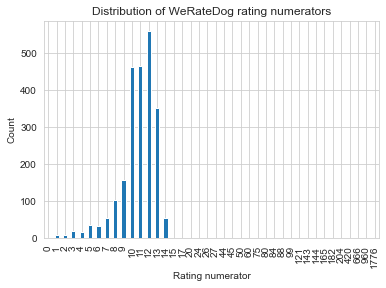

In [444]:
tweets.rating_numerator.value_counts().sort_index().plot.bar().set_title("Distribution of WeRateDog rating numerators")
plt.xlabel("Rating numerator")
plt.ylabel("Count")

Text(0, 0.5, 'Count')

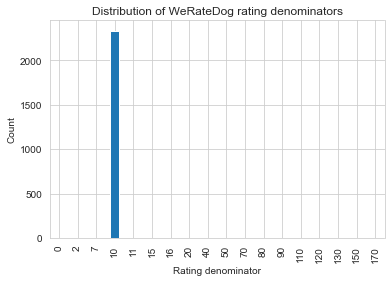

In [445]:
tweets.rating_denominator.value_counts().sort_index().plot.bar().set_title("Distribution of WeRateDog rating denominators")
plt.xlabel("Rating denominator")
plt.ylabel("Count")

In [155]:
tweets.query('rating_denominator != 10')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
313,835246439529840640,8.352460e+17,2.625958e+07,2017-02-24 21:54:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@jonnysun @Lin_Manuel ok jomny I know you're e...,NaN,NaN,NaN,NaN,960,0,None,None,None,None,None
342,832088576586297345,8.320875e+17,3.058208e+07,2017-02-16 04:45:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@docmisterio account started on 11/15/15,NaN,NaN,NaN,NaN,11,15,None,None,None,None,None
433,820690176645140481,NaN,NaN,2017-01-15 17:52:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",The floofs have been released I repeat the flo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/820690176...,84,70,None,None,None,None,None
516,810984652412424192,NaN,NaN,2016-12-19 23:06:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Sam. She smiles 24/7 &amp; secretly aspir...,NaN,NaN,NaN,"https://www.gofundme.com/sams-smile,https://tw...",24,7,Sam,None,None,None,None
784,775096608509886464,NaN,NaN,2016-09-11 22:20:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...","RT @dog_rates: After so many requests, this is...",7.403732e+17,4.196984e+09,2016-06-08 02:41:38 +0000,https://twitter.com/dog_rates/status/740373189...,9,11,None,None,None,None,None
902,758467244762497024,NaN,NaN,2016-07-28 01:00:57 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Why does this never happen at my front door......,NaN,NaN,NaN,https://twitter.com/dog_rates/status/758467244...,165,150,None,None,None,None,None
1068,740373189193256964,NaN,NaN,2016-06-08 02:41:38 +0000,"<a href=""http://twitter.com/download/iphone"" r...","After so many requests, this is Bretagne. She ...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/740373189...,9,11,None,None,None,None,None
1120,731156023742988288,NaN,NaN,2016-05-13 16:15:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to this unbelievably well behaved sq...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/731156023...,204,170,this,None,None,None,None
1165,722974582966214656,NaN,NaN,2016-04-21 02:25:47 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Happy 4/20 from the squad! 13/10 for all https...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/722974582...,4,20,None,None,None,None,None
1202,716439118184652801,NaN,NaN,2016-04-03 01:36:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bluebert. He just saw that both #Final...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/716439118...,50,50,Bluebert,None,None,None,None


In [168]:
tweets.name.unique()

array(['Phineas', 'Tilly', 'Archie', 'Darla', 'Franklin', 'None', 'Jax',
       'Zoey', 'Cassie', 'Koda', 'Bruno', 'Ted', 'Stuart', 'Oliver',
       'Jim', 'Zeke', 'Ralphus', 'Canela', 'Gerald', 'Jeffrey', 'such',
       'Maya', 'Mingus', 'Derek', 'Roscoe', 'Waffles', 'Jimbo', 'Maisey',
       'Lilly', 'Earl', 'Lola', 'Kevin', 'Yogi', 'Noah', 'Bella',
       'Grizzwald', 'Rusty', 'Gus', 'Stanley', 'Alfy', 'Koko', 'Rey',
       'Gary', 'a', 'Elliot', 'Louis', 'Jesse', 'Romeo', 'Bailey',
       'Duddles', 'Jack', 'Emmy', 'Steven', 'Beau', 'Snoopy', 'Shadow',
       'Terrance', 'Aja', 'Penny', 'Dante', 'Nelly', 'Ginger', 'Benedict',
       'Venti', 'Goose', 'Nugget', 'Cash', 'Coco', 'Jed', 'Sebastian',
       'Walter', 'Sierra', 'Monkey', 'Harry', 'Kody', 'Lassie', 'Rover',
       'Napolean', 'Dawn', 'Boomer', 'Cody', 'Rumble', 'Clifford',
       'quite', 'Dewey', 'Scout', 'Gizmo', 'Cooper', 'Harold', 'Shikha',
       'Jamesy', 'Lili', 'Sammy', 'Meatball', 'Paisley', 'Albus',
       'Nept

In [45]:
tweets[tweets.expanded_urls.isnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
30,886267009285017600,8.862664e+17,2.281182e+09,2017-07-15 16:51:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@NonWhiteHat @MayhewMayhem omg hello tanner yo...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
55,881633300179243008,8.816070e+17,4.738443e+07,2017-07-02 21:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@roushfenway These are good dogs but 17/10 is ...,NaN,NaN,NaN,NaN,17,10,None,None,None,None,None
64,879674319642796034,8.795538e+17,3.105441e+09,2017-06-27 12:14:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@RealKentMurphy 14/10 confirmed,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
113,870726314365509632,8.707262e+17,1.648776e+07,2017-06-02 19:38:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@ComplicitOwl @ShopWeRateDogs &gt;10/10 is res...,NaN,NaN,NaN,NaN,10,10,None,None,None,None,None
148,863427515083354112,8.634256e+17,7.759620e+07,2017-05-13 16:15:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@Jack_Septic_Eye I'd need a few more pics to p...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
179,857214891891077121,8.571567e+17,1.806710e+08,2017-04-26 12:48:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@Marc_IRL pixelated af 12/10,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
185,856330835276025856,NaN,NaN,2017-04-24 02:15:55 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @Jenna_Marbles: @dog_rates Thanks for ratin...,8.563302e+17,66699013.0,2017-04-24 02:13:14 +0000,NaN,14,10,None,None,None,None,None
186,856288084350160898,8.562860e+17,2.792810e+08,2017-04-23 23:26:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@xianmcguire @Jenna_Marbles Kardashians wouldn...,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
188,855862651834028034,8.558616e+17,1.943518e+08,2017-04-22 19:15:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@dhmontgomery We also gave snoop dogg a 420/10...,NaN,NaN,NaN,NaN,420,10,None,None,None,None,None
189,855860136149123072,8.558585e+17,1.361572e+07,2017-04-22 19:05:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@s8n You tried very hard to portray this good ...,NaN,NaN,NaN,NaN,666,10,None,None,None,None,None


### Quality
- contains retweets --> done
- contains replies --> done
- contains non-dog related ratings, tweets without images (https://twitter.com/dog_rates/status/828361771580813312) --> done
- numerator and denominator are not all base 10
- tweets: wrong numerator/denominator for id=66628740622469529 and id=835246439529840640 and id=740373189193256964 and id=881633300179243008
- tweets: outlier ratings for ids 680494726643068929, 778027034220126208, 786709082849828864  due to delimiter '.'
- tweets: outlier ratings for ids 670842764863651840, 749981277374128128	
- wrong names "a","an","light","old" et al. --> done
- contains invalid ids (see error_ids) --> done
- source contains html a tag
- remove redundant/unnecesary columns --> done



### Tidiness
- wrong datatypes for timestamp --> done
- index not set to tweet_id --> done
- two separate tables for tweets --> done
- predictions in separate table --> done
- multiple columns for dog stages (if categorical, columns can be merged) --> done

## Clean

We do not want to perform cleaning steps on the original data, in case we want to roll back. Therefore let's first create copies of the original dataframes before starting cleaning.

In [256]:
"""Copy dataframes"""
tweets_clean = tweets.copy()
predictions_clean = predictions.copy()
tweets_extended_clean = tweets_extended.copy()

### Issue 1: Tweets data contains also retweets

#### Define

Retweets can be determined via entry in columns `retweeted_status_id`, `retweeted_status_user_id` or `retweeted_status_timestamp`. As every retweet has entries in all three columns, we can use either one to determine if a row represents a retweet. We remove a row from the dataset, if it contains data in column `retweeted_status_timestamp`.

#### Code

In [257]:
"""Filter tweets by rows where retweeted_status_timestamp is null"""
tweets_clean = tweets_clean[tweets_clean['retweeted_status_timestamp'].isnull()]
tweets_clean.sample()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2262,667546741521195010,NaN,NaN,2015-11-20 03:35:20 +0000,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",Here is George. George took a selfie of his ne...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/667546741...,9,10,George,None,None,None,None


#### Test

In [258]:
"""Check that dataframe does not contain retweets after cleaning"""
cleaned = tweets_clean.query('retweeted_status_timestamp.notnull() | retweeted_status_user_id.notnull() | retweeted_status_id.notnull()')
assert cleaned.shape[0] == 0

### Issue 2: Tweets data contains also replies

#### Define

Replies can be determined via entry in columns `in_reply_to_status_id` or `in_reply_to_user_id`. As every reply has entries in all two columns, we can use either one to determine if a row represents a retweet. We remove a row from the dataset, if it contains data in column `in_reply_to_status_id`.

Lastly we remove the now unnecessary columns `in_reply_to_status_id` and `in_reply_to_user_id`.

#### Code

In [259]:
"""Filter tweets by rows where retweeted_status_timestamp is null. Lastly drop unnecessary columns."""
tweets_clean = tweets_clean[tweets_clean['in_reply_to_status_id'].isnull()]
tweets_clean.sample()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
88,875097192612077568,NaN,NaN,2017-06-14 21:06:43 +0000,"<a href=""http://twitter.com/download/iphone"" r...",You'll get your package when that precious man...,NaN,NaN,NaN,https://twitter.com/drboondoc/status/874413398...,13,10,None,None,None,None,None


#### Test

In [260]:
"""Check that dataframe does not contain replies after cleaning"""
cleaned = tweets_clean.query('in_reply_to_status_id.notnull() | in_reply_to_user_id.notnull()')
assert cleaned.shape[0] == 0

### Issue 3: Tweets data contains tweets without images

#### Define

We remove all rows without entries in column `expanded_urls`

#### Code

In [261]:
"""Filter tweets by rows where expanded_urls is not null"""
tweets_clean = tweets_clean.query('expanded_urls.notnull()')
tweets_clean.sample()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
478,815966073409433600,NaN,NaN,2017-01-02 17:00:46 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here's a pupper with squeaky hiccups. Please e...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/815966073...,13,10,None,None,None,pupper,None


#### Test

In [262]:
"""Check that dataframe does not contain tweets without images after cleaning"""
cleaned = tweets_clean.query('expanded_urls.isnull()')
assert cleaned.shape[0] == 0

### Issue 4: Index not set to tweet_id and multiple tweet tables and tweets table contains invalid ids (see error_ids)

#### Define

We set the index for tables `tweets_clean`, `tweets_extended_clean` and `predictions_clean` to `tweet_id`. Then we join `tweets_extended_clean` and `predictions_clean` on `tweets_clean` to obtain a single table representing tweets. By using a right join, we remove invalid ids from `error_ids` from the tweets dataset.

#### Code

In [263]:
"""Set index and join the tables"""
tweets_clean.set_index('tweet_id', inplace=True)
tweets_extended_clean.set_index('id', inplace=True)
predictions_clean.set_index('tweet_id', inplace=True)

tweets_clean = tweets_clean.join(tweets_extended_clean, how="inner")
tweets_clean = tweets_clean.join(predictions_clean, how="inner")

In [264]:
tweets_clean.sample()

,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
676237365392908289,NaN,NaN,2015-12-14 03:08:46 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to Winston. He has no respect for th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/676237365...,8,...,1,French_bulldog,0.961996,True,Chihuahua,0.021793,True,Boston_bull,0.006916,True


In [265]:
tweets_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1963 entries, 892420643555336193 to 666020888022790149
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   in_reply_to_status_id       0 non-null      float64
 1   in_reply_to_user_id         0 non-null      float64
 2   timestamp                   1963 non-null   object 
 3   source                      1963 non-null   object 
 4   text                        1963 non-null   object 
 5   retweeted_status_id         0 non-null      float64
 6   retweeted_status_user_id    0 non-null      float64
 7   retweeted_status_timestamp  0 non-null      object 
 8   expanded_urls               1963 non-null   object 
 9   rating_numerator            1963 non-null   int64  
 10  rating_denominator          1963 non-null   int64  
 11  name                        1963 non-null   object 
 12  doggo                       1963 non-null   object 
 13  fl

#### Test

In [267]:
"""Check that tweets_clean contains extended columns after joining"""
extended_columns = ["retweeted","retweet_count","favorite_count","p1","p1_conf","p1_dog"]
assert all(col in list(tweets_clean.columns) for col in extended_columns)

### Issue 5: multiple columns for dog stages

#### Define

We replace all `None`-strings for columns `doggo`, `puppo`, `puppyer`, `floofer` by `np.NaN`. Afterwards, we merge these columns into a single column `dog_stages`. In cases where multiple stages exist, these are separated by `,` in the new column.

#### Code

In [268]:
"""Replace None strings by np.nan"""
tweets_clean[['doggo','floofer','pupper','puppo']]=tweets_clean[['doggo','floofer','pupper','puppo']].replace(to_replace="None", value=np.nan)

In [269]:
"""Create new stages column and drop columns doggo, floofer, pupper, puppo"""
tweets_clean['stages'] = tweets_clean[['doggo','floofer','pupper','puppo']].apply(lambda x: x.str.cat(sep=','), axis=1)
tweets_clean.drop(columns=["doggo","floofer","pupper","puppo"], inplace=True)

In [270]:
"""Replace empty string with None"""
tweets_clean['stages'] = tweets_clean['stages'].replace(r'^\s*$', 'None', regex=True)

In [271]:
tweets_clean.stages.value_counts()

None             1661
pupper            201
doggo              62
puppo              22
doggo,pupper        8
floofer             7
doggo,puppo         1
doggo,floofer       1
Name: stages, dtype: int64

#### Test

In [272]:
"""Check that separate stage columns are removed"""
assert all(_ not in tweets_clean.columns for _ in ['doggo','floofer','pupper','puppo'])

### Issue 6: Redundant columns

#### Define

We remove the following columns from the dataframe: `in_reply_to_status_id`, `in_reply_to_user_id`, `source`, `retweeted_status_id`, `retweeted_status_user_id`, `retweeted_status_timestamp`, `retweeted`.

#### Code

In [273]:
"""Set index and join the two tweets-related tables"""
tweets_clean.drop(columns=['in_reply_to_status_id', 'in_reply_to_user_id', 'source', 
                           'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp', 
                           'retweeted'], inplace=True)

In [274]:
tweets_clean.sample()

,timestamp,text,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,stages
785927819176054784,2016-10-11 19:39:28 +0000,This is Lucy. She's strives to be the best pot...,https://twitter.com/dog_rates/status/785927819...,12,10,Lucy,3082,11101,https://pbs.twimg.com/media/CugtKeXWEAAamDZ.jpg,1,teddy,0.97207,False,toy_poodle,0.008493,True,chow,0.002883,True,None


#### Test

In [275]:
"""Check that redundant columns are removed"""
assert all(_ not in tweets_clean.columns for _ in ['in_reply_to_status_id', 'in_reply_to_user_id', 'source', 
                           'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp', 
                           'text_extended', 'retweeted', 'created_at'])

### Issue 7: Wrong datatype for timestamp

#### Define

We set the datatype for `timestamp` column from object to datetime.

#### Code

In [276]:
"""Set the correct datatypes"""
tweets_clean['timestamp'] =  pd.to_datetime(tweets_clean['timestamp'])

In [277]:
tweets_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1963 entries, 892420643555336193 to 666020888022790149
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   timestamp           1963 non-null   datetime64[ns, UTC]
 1   text                1963 non-null   object             
 2   expanded_urls       1963 non-null   object             
 3   rating_numerator    1963 non-null   int64              
 4   rating_denominator  1963 non-null   int64              
 5   name                1963 non-null   object             
 6   retweet_count       1963 non-null   int64              
 7   favorite_count      1963 non-null   int64              
 8   jpg_url             1963 non-null   object             
 9   img_num             1963 non-null   int64              
 10  p1                  1963 non-null   object             
 11  p1_conf             1963 non-null   float64            
 12  p1_

#### Test

In [278]:
"""Check that timestamp has dtype datetime"""
assert tweets_clean.timestamp.dtype == 'datetime64[ns, UTC]'

### Issue 8: Wrong names "a","an","light","old" et al.

#### Define

We expect a name to start with a capital letter. We therefore replace all names in `tweets_clean.name` starting with lowercase letters by 'None'.

#### Code

In [279]:
"""Set the correct datatypes"""
tweets_clean['name'] = tweets_clean['name'].str.replace(r'^[a-z].*','None', regex=True)

In [280]:
tweets_clean.name.value_counts()

None           621
Cooper          10
Oliver          10
Charlie         10
Penny            9
              ... 
Shakespeare      1
Lillie           1
Humphrey         1
Dietrich         1
Roscoe           1
Name: name, Length: 911, dtype: int64

#### Test

In [281]:
"""Check that no lower case names are present"""
assert sum(tweets_clean['name'].str.match(r'^[a-z].*')) == 0

### Issue 9: wrong numerator/denominator for id=66628740622469529 and id=835246439529840640 and id=740373189193256964 and id=881633300179243008; ratings are not all base 10

#### Define

As the number of affected rows are small, we manually clean the tweets where wrong ratings were selected by using the correct ratings from the text. Ratings with deliberately changed denominator are recalculated with base 10.

#### Code

In [282]:
tweets_clean.query('rating_denominator != 10')

,timestamp,text,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,stages
820690176645140481,2017-01-15 17:52:40+00:00,The floofs have been released I repeat the flo...,https://twitter.com/dog_rates/status/820690176...,84,70,None,3092,11867,https://pbs.twimg.com/media/C2OtWr0VQAEnS9r.jpg,2,West_Highland_white_terrier,0.872064,True,kuvasz,0.059526,True,Samoyed,0.037400,True,None
810984652412424192,2016-12-19 23:06:23+00:00,Meet Sam. She smiles 24/7 &amp; secretly aspir...,"https://www.gofundme.com/sams-smile,https://tw...",24,7,Sam,1375,5179,https://pbs.twimg.com/media/C0EyPZbXAAAceSc.jpg,1,golden_retriever,0.871342,True,Tibetan_mastiff,0.036708,True,Labrador_retriever,0.025823,True,None
758467244762497024,2016-07-28 01:00:57+00:00,Why does this never happen at my front door......,https://twitter.com/dog_rates/status/758467244...,165,150,None,2100,4607,https://pbs.twimg.com/ext_tw_video_thumb/75846...,1,Labrador_retriever,0.436377,True,Chihuahua,0.113956,True,American_Staffordshire_terrier,0.099689,True,None
740373189193256964,2016-06-08 02:41:38+00:00,"After so many requests, this is Bretagne. She ...",https://twitter.com/dog_rates/status/740373189...,9,11,None,12532,33383,https://pbs.twimg.com/media/CkZVdJ6WYAAXZ5A.jpg,3,golden_retriever,0.807644,True,kuvasz,0.101286,True,Labrador_retriever,0.023785,True,None
731156023742988288,2016-05-13 16:15:54+00:00,Say hello to this unbelievably well behaved sq...,https://twitter.com/dog_rates/status/731156023...,204,170,None,1183,3631,https://pbs.twimg.com/media/CiWWhVNUYAAab_r.jpg,1,lakeside,0.501767,False,breakwater,0.051351,False,king_penguin,0.049444,False,None
722974582966214656,2016-04-21 02:25:47+00:00,Happy 4/20 from the squad! 13/10 for all https...,https://twitter.com/dog_rates/status/722974582...,4,20,None,1469,3879,https://pbs.twimg.com/media/CgiFjIpWgAA4wVp.jpg,1,Great_Dane,0.246762,True,Greater_Swiss_Mountain_dog,0.126131,True,Weimaraner,0.085297,True,None
716439118184652801,2016-04-03 01:36:11+00:00,This is Bluebert. He just saw that both #Final...,https://twitter.com/dog_rates/status/716439118...,50,50,Bluebert,198,2267,https://pbs.twimg.com/media/CfFNk7cWAAA-hND.jpg,1,Siberian_husky,0.396495,True,malamute,0.317053,True,Eskimo_dog,0.273419,True,None
713900603437621249,2016-03-27 01:29:02+00:00,Happy Saturday here's 9 puppers on a bench. 99...,https://twitter.com/dog_rates/status/713900603...,99,90,None,686,2692,https://pbs.twimg.com/media/CehIzzZWQAEyHH5.jpg,1,golden_retriever,0.371816,True,cocker_spaniel,0.177413,True,Irish_setter,0.092725,True,None
710658690886586372,2016-03-18 02:46:49+00:00,Here's a brigade of puppers. All look very pre...,https://twitter.com/dog_rates/status/710658690...,80,80,None,530,2205,https://pbs.twimg.com/media/CdzETn4W4AAVU5N.jpg,1,soft-coated_wheaten_terrier,0.948617,True,Dandie_Dinmont,0.018664,True,cairn,0.015943,True,None
709198395643068416,2016-03-14 02:04:08+00:00,"From left to right:\nCletus, Jerome, Alejandro...",https://twitter.com/dog_rates/status/709198395...,45,50,None,607,2334,https://pbs.twimg.com/media/CdeUKpcWoAAJAWJ.jpg,1,borzoi,0.490783,True,wire-haired_fox_terrier,0.083513,True,English_setter,0.083184,True,None


In [283]:
"""Manually clean the tweets where wrong ratings were selected by using the correct ratings from the text. Drop the tweet
that was no dog rating"""
tweets_clean.loc[666287406224695296,['rating_numerator','rating_denominator']] = [9,10]
tweets_clean.loc[682962037429899265,['rating_numerator','rating_denominator']] = [10,10]
tweets_clean.loc[722974582966214656,['rating_numerator','rating_denominator']] = [13,10]
tweets_clean.loc[740373189193256964,['rating_numerator','rating_denominator']] = [14,10]
tweets_clean.drop(810984652412424192, inplace=True)

In [284]:
"""Rebase ratings to denominator 10"""
denominator = 10
tweets_clean['rating_numerator'] = pd.to_numeric(tweets_clean['rating_numerator']*denominator//tweets_clean['rating_denominator'])
tweets_clean['rating_denominator'] = denominator

#### Test

In [285]:
tweets_clean.sample(5)

,timestamp,text,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,stages
668226093875376128,2015-11-22 00:34:50+00:00,Sneaky dog here. Tuba player has no clue. 10/1...,https://twitter.com/dog_rates/status/668226093...,10,10,None,90,263,https://pbs.twimg.com/media/CUYEFlQXAAUkPGm.jpg,1,trombone,0.390339,False,cornet,0.314149,False,French_horn,0.255182,False,None
711363825979756544,2016-03-20 01:28:47+00:00,"""Please, no puparazzi"" 11/10 https://t.co/nJIX...",https://twitter.com/dog_rates/status/711363825...,11,10,None,1066,3432,https://pbs.twimg.com/media/Cd9Fn5QUMAAYMT4.jpg,1,Pembroke,0.750906,True,Cardigan,0.241152,True,basenji,0.002640,True,None
704819833553219584,2016-03-02 00:05:17+00:00,This is Chesterson. He's a Bolivian Scoop Dog....,https://twitter.com/dog_rates/status/704819833...,7,10,Chesterson,919,2509,https://pbs.twimg.com/media/CcgF5ovW8AACrEU.jpg,1,guinea_pig,0.994776,False,hamster,0.004069,False,wood_rabbit,0.000206,False,None
849336543269576704,2017-04-04 19:03:06+00:00,At first I thought this was a dog because of t...,https://twitter.com/dog_rates/status/849336543...,11,10,None,1744,10816,https://pbs.twimg.com/media/C8lzFC4XcAAQxB4.jpg,1,patio,0.521788,False,prison,0.149544,False,restaurant,0.027153,False,None
717841801130979328,2016-04-06 22:29:56+00:00,This is Barclay. His father was a banana. 11/1...,https://twitter.com/dog_rates/status/717841801...,11,10,Barclay,561,2326,https://pbs.twimg.com/media/CfZJTphWAAAl5Ys.jpg,1,Brittany_spaniel,0.922876,True,English_springer,0.070113,True,bath_towel,0.002561,False,None


In [286]:
assert tweets_clean.query('rating_denominator != 10').shape[0] == 0

### Issue 10: Outlier ratings

#### Define

We manually clean the ratings for ids 680494726643068929, 778027034220126208, 786709082849828864, which were received due to missinterpretation of float values.

We also drop outliers 670842764863651840 (funny, Snoop Dogg :-), 749981277374128128.

#### Code

In [287]:
"""Set the correct ratings"""
tweets_clean.loc[680494726643068929,['rating_numerator','rating_denominator']] = [11,10]
tweets_clean.loc[778027034220126208,['rating_numerator','rating_denominator']] = [11,10]
tweets_clean.loc[786709082849828864,['rating_numerator','rating_denominator']] = [10,10]

In [288]:
"""Drop outlier values"""
tweets_clean.drop([670842764863651840, 749981277374128128], inplace=True)

#### Test

In [289]:
"""Check that timestamp has dtype datetime"""
assert tweets_clean.query('rating_numerator > 30').shape[0] == 0

In [292]:
"""Output dataframe to new csv"""
tweets_clean.to_csv('twitter_archive_master.csv', index = True)

## Analysis and visualisation

Research questions:
- What is the distribution of ratings?
- Is there a correlation between rating and retweets?
- Do ratings for different dog stages differ?
- Are some dog breedings more liked, meaning favourited or retweeted?
- What was the most retweeted dog tweet between 2015 and 2017?

Before we start analysing, let us first filter the dataset for tweets which are predicted to be related to dogs.

In [314]:
"""Filter dataset by tweets with images which are predicted to be dogs"""
tweets_analysis = tweets_clean.query('p1_dog')
tweets_analysis.sample(3)

,timestamp,text,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,stages
707297311098011648,2016-03-08 20:09:54+00:00,This is Cassie. She can go from sweet to scary...,https://twitter.com/dog_rates/status/707297311...,10,10,Cassie,737,2653,https://pbs.twimg.com/media/CdDTJLMW4AEST--.jpg,1,Blenheim_spaniel,0.370717,True,Shih-Tzu,0.201566,True,black-footed_ferret,0.101559,False,None
673580926094458881,2015-12-06 19:13:01+00:00,When you ask your professor about extra credit...,https://twitter.com/dog_rates/status/673580926...,8,10,None,249,766,https://pbs.twimg.com/media/CVkKRqOXIAEX83-.jpg,1,beagle,0.985062,True,basset,0.006418,True,Walker_hound,0.003533,True,None
670290420111441920,2015-11-27 17:17:44+00:00,This is Sandra. She's going skydiving. Nice ad...,https://twitter.com/dog_rates/status/670290420...,11,10,Sandra,259,638,https://pbs.twimg.com/media/CU1Zgk7UcAAjw2t.jpg,1,Chihuahua,0.368876,True,Pomeranian,0.282102,True,papillon,0.178795,True,None


### Research question 1: What is the distribution of ratings, retweets and favorites?

In [321]:
"""Descriptive analysis of rating distribution"""
tweets_analysis[['rating_numerator','retweet_count','favorite_count']].describe()

,rating_numerator,retweet_count,favorite_count
count,1454.000000,1454.000000,1454.000000
mean,10.905089,2333.242779,8255.204264
std,1.690201,4244.639993,12034.494353
min,2.000000,11.000000,67.000000
25%,10.000000,539.250000,1899.250000
50%,11.000000,1181.000000,3911.000000
75%,12.000000,2685.000000,10284.500000
max,14.000000,73093.000000,148713.000000


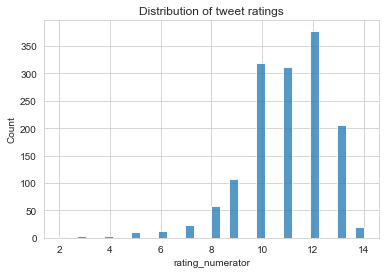

In [447]:
"""Plot rating distribution"""
sns.set_style("whitegrid", {'axes.grid' : True})
ax = sns.histplot(data=tweets_analysis, x="rating_numerator")
ax.set_title("Distribution of tweet ratings")
plt.savefig("tweet_ratings.jpg")

Text(0.5, 1.0, 'Distribution of number of retweets')

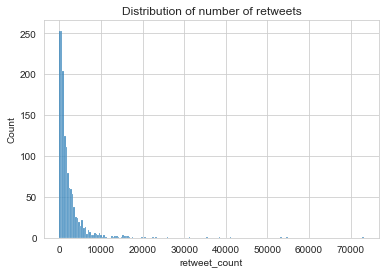

In [333]:
"""Plot retweets distribution"""
sns.set_style("whitegrid", {'axes.grid' : True})
sns.histplot(data=tweets_analysis, x="retweet_count").set_title("Distribution of number of retweets")

Text(0.5, 1.0, 'Distribution of number of likes')

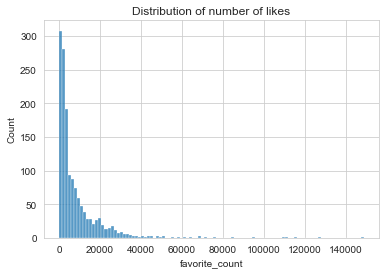

In [334]:
"""Plot favorites distribution"""
sns.histplot(data=tweets_analysis, x="favorite_count").set_title("Distribution of number of likes")

Ratings are approximately normal-distributed centered around 11. We can therefore say that on average, dogs are rated above 10. Message here is probably that basically every dog is at least a 10 :-)

Both `favorite_count` and `retweet_count` are right-skewed, meaning most of the tweets have a small number for retweets/likes only with some outliers which "go viral".

### Reseach question 2: Is there a correlation between rating, likes and retweets?

Text(0.5, 1.0, 'Number of retweets vs. Rating per tweet')

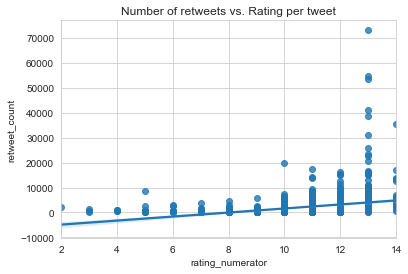

In [440]:
sns.regplot(x="rating_numerator", y="retweet_count", data=tweets_analysis).set_title("Number of retweets vs. Rating per tweet")

In [365]:
df = tweets_analysis[['rating_numerator','retweet_count','favorite_count']]
df['intercept'] = 1
model = sm.OLS(df['retweet_count'], df[['rating_numerator', 'intercept']])
res = model.fit()
res.summary()

C:\Users\Lenovo\Anaconda3\envs\py3.6\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          retweet_count   R-squared:                       0.104
Model:                            OLS   Adj. R-squared:                  0.103
Method:                 Least Squares   F-statistic:                     168.1
Date:                Sat, 17 Jul 2021   Prob (F-statistic):           1.87e-36
Time:                        19:43:00   Log-Likelihood:                -14129.
No. Observations:                1454   AIC:                         2.826e+04
Df Residuals:                    1452   BIC:                         2.827e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
rating_numerator   808.9252     62.392     12.965      0.000     686.536     931.314
intercept        -6488.1589    688.514     -9.423      0.000   -7838.747   -5137.570
==============================================================================
Omnibus:                     2113.653   Durbin-Watson:                   1.890
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           691825.215
Skew:                           8.407   Prob(JB):                         0.00
Kurtosis:                     108.530   Cond. No.                         72.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0.5, 1.0, 'Number of favorites vs. Rating per tweet')

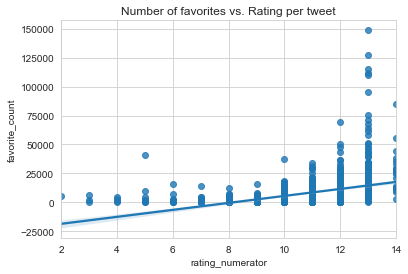

In [439]:
sns.regplot(x="rating_numerator", y="favorite_count", data=tweets_analysis).set_title("Number of favorites vs. Rating per tweet")

In [366]:
df = tweets_analysis[['rating_numerator','retweet_count','favorite_count']]
df['intercept'] = 1
model = sm.OLS(df['favorite_count'], df[['rating_numerator', 'intercept']])
res = model.fit()
res.summary()

C:\Users\Lenovo\Anaconda3\envs\py3.6\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         favorite_count   R-squared:                       0.180
Model:                            OLS   Adj. R-squared:                  0.179
Method:                 Least Squares   F-statistic:                     318.0
Date:                Sat, 17 Jul 2021   Prob (F-statistic):           1.75e-64
Time:                        19:43:45   Log-Likelihood:                -15580.
No. Observations:                1454   AIC:                         3.116e+04
Df Residuals:                    1452   BIC:                         3.117e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
rating_numerator  3018.1691    169.238     17.834      0.000    2686.193    3350.145
intercept        -2.466e+04   1867.572    -13.203      0.000   -2.83e+04    -2.1e+04
==============================================================================
Omnibus:                     1521.114   Durbin-Watson:                   1.575
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           110827.172
Skew:                           5.012   Prob(JB):                         0.00
Kurtosis:                      44.579   Cond. No.                         72.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0.5, 1.0, 'Number of favorites vs. number of retweets per tweet')

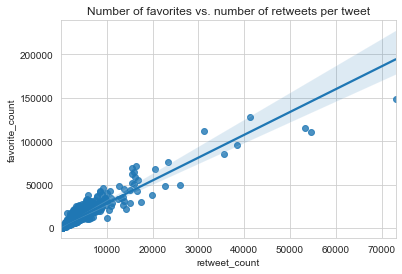

In [438]:
sns.regplot(x="retweet_count", y="favorite_count", data=tweets_analysis).set_title("Number of favorites vs. number of retweets per tweet")

In [364]:
df = tweets_analysis[['retweet_count','favorite_count']]
df['intercept'] = 1
model = sm.OLS(df['favorite_count'], df[['retweet_count', 'intercept']])
res = model.fit()
res.summary()

C:\Users\Lenovo\Anaconda3\envs\py3.6\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         favorite_count   R-squared:                       0.859
Model:                            OLS   Adj. R-squared:                  0.859
Method:                 Least Squares   F-statistic:                     8875.
Date:                Sat, 17 Jul 2021   Prob (F-statistic):               0.00
Time:                        19:42:05   Log-Likelihood:                -14297.
No. Observations:                1454   AIC:                         2.860e+04
Df Residuals:                    1452   BIC:                         2.861e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
retweet_count     2.6284      0.028     94.208      0.000       2.574       2.683
intercept      2122.6030    135.100     15.711      0.000    1857.592    2387.614
==============================================================================
Omnibus:                      346.864   Durbin-Watson:                   0.795
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14403.085
Skew:                           0.259   Prob(JB):                         0.00
Kurtosis:                      18.410   Cond. No.                     5.53e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.53e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The results of the linear regression models suggest, that changes in the number of likes and retweets are associated with changes in the rating.

### Research question 3: Do ratings, likes and retweets for different dog stages differ?

In [346]:
tweets_by_stage = tweets_analysis[['stages','retweet_count','favorite_count','rating_numerator']].groupby('stages').median()
tweets_by_stage

,retweet_count,favorite_count,rating_numerator
stages,,,
None,1142.5,3665.0,11.0
doggo,2227.0,10582.0,12.0
"doggo,floofer",2894.0,15231.0,11.0
"doggo,pupper",2134.0,8603.0,12.0
"doggo,puppo",16573.0,42918.0,13.0
floofer,2711.0,9727.0,12.0
pupper,990.5,2944.5,11.0
puppo,2190.0,9982.0,12.0


Text(0, 0.5, 'Rating')

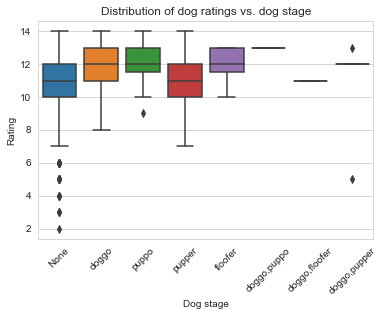

In [437]:
plt.xticks(rotation=45)
sns.boxplot(x="stages", y="rating_numerator", data=tweets_analysis).set_title('Distribution of dog ratings vs. dog stage')
plt.xlabel("Dog stage")
plt.ylabel("Rating")

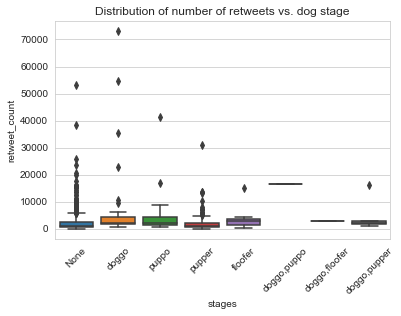

In [452]:
plt.xticks(rotation=45)
sns.boxplot(x="stages", y="retweet_count", data=tweets_analysis).set_title('Distribution of number of retweets vs. dog stage')
plt.savefig("retweets-by-dog-stage.jpg")

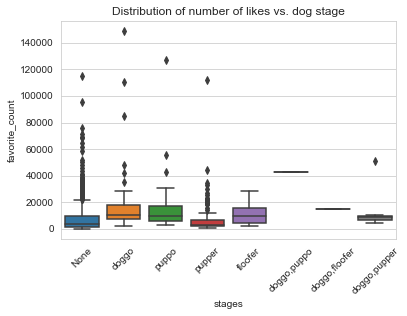

In [448]:
plt.xticks(rotation=45)
sns.boxplot(x="stages", y="favorite_count", data=tweets_analysis).set_title('Distribution of number of likes vs. dog stage')
plt.savefig("likes-by-dog-stage.jpg")

From the plot it seems that considering the median, tweets concerning puppos and doggos are best-rated, have the highest retweet counts and the highest count of likes. Nevertheless the difference does not seem significant.

### Research question 4: Are some dog breedings more liked, meaning favourited or retweeted, by the followers?

In [386]:
"""Filter tweets by popular breeds"""
pupular_breeds = list(tweets_analysis.p1.value_counts()[:9].index)
tweets_analysis_popular_breeds = tweets_analysis[tweets_analysis['p1'].isin(pupular_breeds)]
tweets_analysis_popular_breeds.p1.value_counts()

golden_retriever      136
Labrador_retriever     91
Pembroke               88
Chihuahua              78
pug                    54
chow                   41
Samoyed                39
Pomeranian             38
toy_poodle             36
Name: p1, dtype: int64

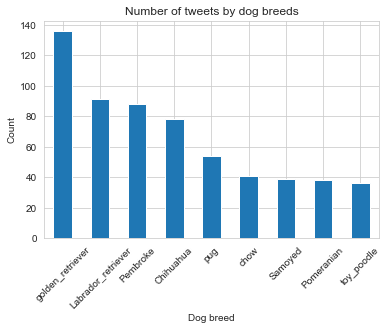

In [449]:
"""Plot distribution of breeds"""
tweets_analysis_popular_breeds.p1.value_counts().plot(kind="bar").set_title('Number of tweets by dog breeds')
plt.xticks(rotation=45)
plt.xlabel("Dog breed")
plt.ylabel("Count")
plt.savefig("tweets-by-breed.jpg")

In [446]:
tweets_analysis_popular_breeds[['p1','rating_numerator','retweet_count','favorite_count']].groupby("p1").describe()

rating_numerator                                          \
                              count       mean       std   min    25%   50%   
p1                                                                            
Chihuahua                      78.0  10.692308  1.982440   3.0  10.00  11.0   
Labrador_retriever             91.0  11.098901  1.317025   7.0  10.00  11.0   
Pembroke                       88.0  11.443182  1.721119   4.0  11.00  12.0   
Pomeranian                     38.0  11.157895  0.973329  10.0  10.00  11.0   
Samoyed                        39.0  11.743590  1.332152   7.0  11.00  12.0   
chow                           41.0  11.609756  1.021715  10.0  11.00  12.0   
golden_retriever              136.0  11.580882  1.325282   5.0  11.00  12.0   
pug                            54.0  10.240741  1.912572   3.0   9.25  10.0   
toy_poodle                     36.0  11.027778  1.158475   9.0  10.00  11.0   

                               retweet_count               ...           \
                     75%   max         count         mean  ...      75%   
p1                                                         ...            
Chihuahua           12.0  14.0          78.0  2413.884615  ...  2376.00   
Labrador_retriever  12.0  13.0          91.0  3168.340659  ...  3341.00   
Pembroke            12.0  14.0          88.0  2667.227273  ...  3497.00   
Pomeranian          12.0  14.0          38.0  2367.684211  ...  1957.75   
Samoyed             13.0  14.0          39.0  3739.923077  ...  6116.00   
chow                12.0  13.0          41.0  2402.926829  ...  2848.00   
golden_retriever    12.0  14.0         136.0  3087.529412  ...  3619.00   
pug                 11.0  13.0          54.0  1509.425926  ...  1567.50   
toy_poodle          12.0  13.0          36.0  2042.555556  ...  2017.75   

                            favorite_count                                     \
                        max          count          mean           std    min   
p1                                                                              
Chihuahua           53352.0           78.0   7851.858974  15046.341233  108.0   
Labrador_retriever  73093.0           91.0  10199.296703  17791.646951  271.0   
Pembroke            15472.0           88.0  10115.556818  11015.430443  145.0   
Pomeranian          16269.0           38.0   7146.631579  10905.523303  348.0   
Samoyed             15162.0           39.0  11781.153846  12711.336123  701.0   
chow                20615.0           41.0   8851.707317  11153.412998  388.0   
golden_retriever    23419.0          136.0  11079.007353  11876.275803  169.0   
pug                  8376.0           54.0   5163.277778   7285.316210   97.0   
toy_poodle          17530.0           36.0   5726.722222   8345.661588  223.0   

                                                         
                        25%     50%       75%       max  
p1                                                       
Chihuahua           1117.50  2560.0   9270.25  114894.0  
Labrador_retriever  1955.00  4724.0  13712.00  148713.0  
Pembroke            2768.75  5703.0  13453.50   61757.0  
Pomeranian          1652.75  2686.5   8108.00   58338.0  
Samoyed             2486.50  6471.0  18246.50   47785.0  
chow                3363.00  5960.0   9823.00   68038.0  
golden_retriever    3113.50  7201.5  14494.75   75836.0  
pug                 1453.00  2279.0   5012.75   32382.0  
toy_poodle          1168.75  3544.5   6580.75   43436.0  

[9 rows x 24 columns]

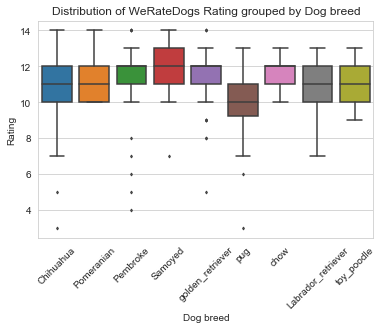

In [451]:
sns.boxplot(data=tweets_analysis_popular_breeds, x="p1", y="rating_numerator", flierprops = dict(markerfacecolor = '0.50', markersize = 2)).set_title("Distribution of WeRateDogs Rating grouped by Dog breed")
plt.xticks(rotation=45)
plt.xlabel("Dog breed")
plt.ylabel("Rating")
plt.savefig("Rating-by-breed.jpg")

Text(0, 0.5, 'Favorite count')

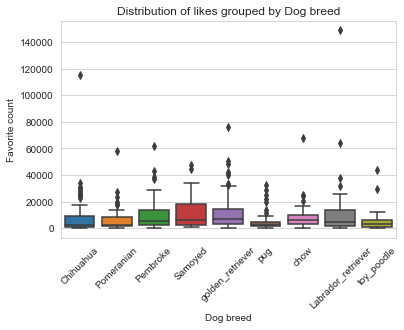

In [436]:
sns.boxplot(data=tweets_analysis_popular_breeds, x="p1", y="favorite_count").set_title("Distribution of likes grouped by Dog breed")
plt.xticks(rotation=45)
plt.xlabel("Dog breed")
plt.ylabel("Favorite count")

The boxplots above indicate that we have correlation between `dog breed` and popularity factors (`retweet_count`, `favorite_count`, `rating_numerator`). In particular, Golden Retriever and Samoyeds receive the highest number of likes and retweets, whereas Pugs underperform in both factors.

### Research question 5: What was the most retweeted dog tweet between 2015 and 2017?

In [420]:
tweets_analysis.sort_values(by="retweet_count", ascending=False).iloc[:3]

,timestamp,text,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,stages
744234799360020481,2016-06-18 18:26:18+00:00,Here's a doggo realizing you can stand in a po...,https://twitter.com/dog_rates/status/744234799...,13,10,None,73093,148713,https://pbs.twimg.com/ext_tw_video_thumb/74423...,1,Labrador_retriever,0.825333,True,ice_bear,0.044681,False,whippet,0.018442,True,doggo
739238157791694849,2016-06-04 23:31:25+00:00,Here's a doggo blowing bubbles. It's downright...,https://twitter.com/dog_rates/status/739238157...,13,10,None,54550,110109,https://pbs.twimg.com/ext_tw_video_thumb/73923...,1,Eskimo_dog,0.503372,True,Siberian_husky,0.390413,True,malamute,0.080901,True,doggo
807106840509214720,2016-12-09 06:17:20+00:00,This is Stephan. He just wants to help. 13/10 ...,https://twitter.com/dog_rates/status/807106840...,13,10,Stephan,53352,114894,https://pbs.twimg.com/ext_tw_video_thumb/80710...,1,Chihuahua,0.505370,True,Pomeranian,0.120358,True,toy_terrier,0.077008,True,None


In [415]:
tweets_analysis.sort_values(by="retweet_count", ascending=False).iloc[0].jpg_url

'https://pbs.twimg.com/ext_tw_video_thumb/744234667679821824/pu/img/1GaWmtJtdqzZV7jy.jpg'

The dataframe above shows that the most retweeted dog tweet was a tweet containing a video of a `Labrador_retriever` swimming in a pool. The tweet can be reached via `https://twitter.com/dog_rates/status/744234799360020481`.

From the table above it can also be seen that the three most retweeted tweets contain videos instead of a dog image. This could lead to the follow up question: Are videos more successful in terms of retweets and likes compared to mere pictures? But answering this is out of the scope of this investigation.